Status: ✅ done

## Exercise 12

---

In this exercise, we explore `Decisions tree` (DT) both from a theoretical as well as practical perspective. After this session,  you should be able to explain what DT is and how it works as well as be able to train and visualize it.

> Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

### Recap on decision trees

---

I have summarized the most important information that you should know in my note on [Decision trees](https://ludekcizinsky.notion.site/Decision-Trees-44e7628f58494f36a8033c3cae9e2c25).

### Impurity functions

---

> Background information and intro to the problem

In this section, we will focus on examining more closely impurity functions, i.e., functions that allow you to evalute how good split you have made. More specifically, we will discuss the following three criterions:

- `Classification error rate`: $$1 - accuracy$$
- `Gini index`: $\sum_{i = 0}^{k} P(i)(1 - P(i))$
- `Entropy`: $-\sum_i^k p(i)\log(p(i))$

where $k$ is number of classes and $P(i)$ is probability of i-th class. In practice, $P(i)$ is computed as: 

$$
P(i) = \frac{n_k}{n}
$$

In words, proportion of samples from the given class divided by the total number of samples in the given node. For accuracy, you not only need the true class $y$, but also the predicted class $\hat{y}$ which you can get by predicting class who has the most samples in the given node.

One more thing I would like to clear out. When we say evaluating how good a split is, we follow the following procedure:

1. Compute the impurity value for each of the splits, i.e., we have two impurity values
2. We actually want just one value so we have to somehow aggregate the above two values. Usually, this is done through weighted average, i.e., we multiply each impurity score by corresponding number of samples and then divide by total number of samples in both nodes.

Let's practice this on the following example:

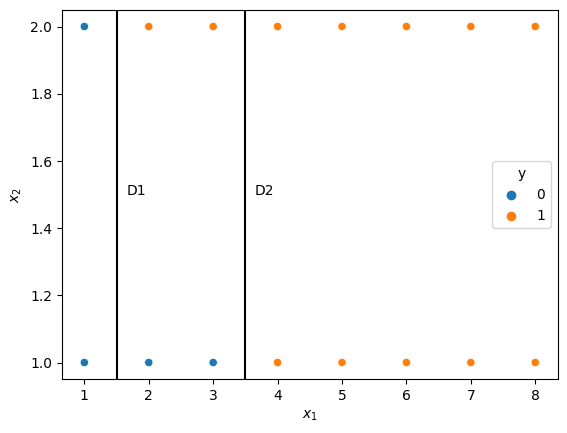

In [ ]:
# Features
x1 = [i for i in range(1, 9, 1)] + [i for i in range(1, 9, 1)]
x2 = [1]*8 + [2]*8

# Response variables
y = np.array([0]*3 + [1]*5 + [0] + [1]*7)

# Wrap into a dataframe
data = {"x1": x1, "x2": x2, "y": y}
df = pd.DataFrame.from_dict(data)

# Show scatter of x1 and x2
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="x1", y="x2", hue="y", ax=ax);
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Add two decisions
D1, D2 = 1.5, 3.5
ax.axvline(D1, color='black');
ax.text(D1 + .15, 1.5, 'D1', color='black');
ax.axvline(D2, color='black');
ax.text(D2 + .15, 1.5, 'D2', color='black');

In the below subsections, we want to examine the following:

- compute the quality of each split based on the above three metrics and interpret the results
- examine if we achieve any information gain by splitting the dataset 

Let's get into work!

> Quality of each split

Let's first split our data according to the two thresholds:

In [ ]:
# D1
left1, right1 = df[df["x1"] < D1], df[df["x1"] >= D1]

# D2
left2, right2 = df[df["x1"] < D2], df[df["x1"] >= D2]

We can also double check the two splits using a couple of subplots:

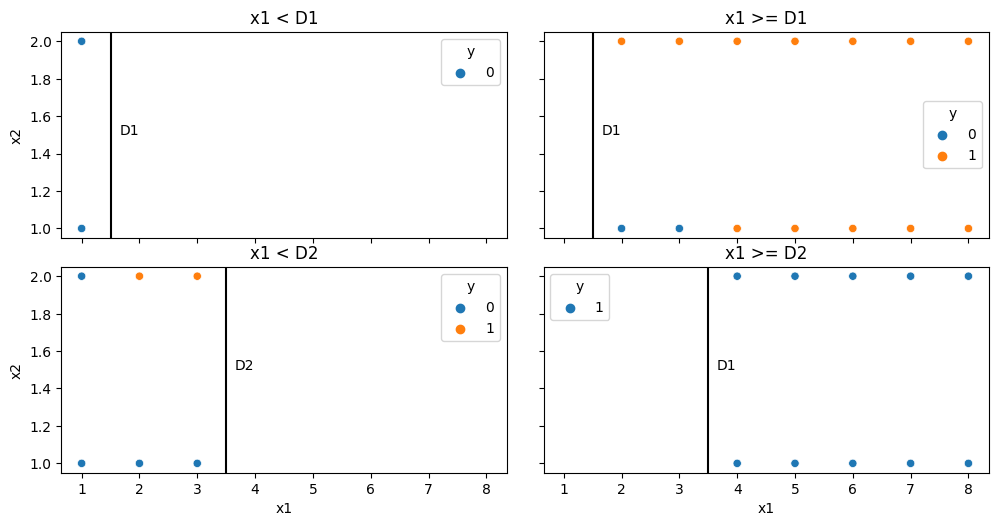

In [ ]:
# Setup plot
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();

# Show the points for both decisions
# -- D1
sns.scatterplot(data=left1, x='x1', y='x2', hue='y', ax=ax[0, 0]);
ax[0, 0].set_title("x1 < D1");
ax[0, 0].axvline(D1, color='black');
ax[0, 0].text(D1 + .15, 1.5, 'D1', color='black');
sns.scatterplot(data=right1, x='x1', y='x2', hue='y', ax=ax[0, 1]);
ax[0, 1].set_title("x1 >= D1");
ax[0, 1].axvline(D1, color='black');
ax[0, 1].text(D1 + .15, 1.5, 'D1', color='black');

# -- D2
sns.scatterplot(data=left2, x='x1', y='x2', hue='y', ax=ax[1, 0]);
ax[1, 0].set_title("x1 < D2");
ax[1, 0].axvline(D2, color='black');
ax[1, 0].text(D2 + .15, 1.5, 'D2', color='black');
sns.scatterplot(data=right2, x='x1', y='x2', hue='y', ax=ax[1, 1]);
ax[1, 1].set_title("x1 >= D2");
ax[1, 1].axvline(D2, color='black');
ax[1, 1].text(D2 + .15, 1.5, 'D1', color='black');

Now, we need to compute the split quality using the above mentioned metrics, I will create a class for this which we can then use later on:

In [ ]:
class SplitQuality:
    """Class gathering several methods for evaluating entropy of given split

    Notes
    -----
    All methods and attributes whose name starts with _ mean that they are private, i.e., these methods 
    should not be called by client. There is no way how I can enforce in python, but just so you know
    the reason behind this as you might encounter it when reading for instance source code of sklearn. :)
    """

    def __init__(self, left=None, right=None, name=None, debug=False):
        # Assign splits
        self._left, self._right = left, right

        # Assign counts in each split
        if left is not None and right is not None:
            self._n1, self._n2 = left.shape[0], right.shape[0]
        else:
            self._n1, self._n2 = None, None
        
        # Assign name of the split
        self._name = name

        # Debug
        self.debug = debug


    def _weighted_average(self, weights, values):
        """Computes weighted average

        Attributes
        ----------
        weights : 1d array
            weights to corresponding values
        
        values : 1d array
            values that we want to take weighted average of (impurities)
        
        Returns
        -------
        wavg : float
            Weighted average of values
        """
        wavg = ((weights*values).sum())/weights.sum()
        return wavg

    def _predict(self, y):
        """Predict to the class with highest count

        Attributes
        ----------
        y : 1d array
            y values corresponding to the given split

        Returns
        -------
        majority_class : int
            Id of the class with highest count        
        """

        counts = [(k, count) for k, count in y.value_counts().to_dict().items()]
        majority_class = sorted(counts, key=lambda t: t[1], reverse=True)[0][0]
        return majority_class
    
    def _get_error_rate(self, y):
        """Returns error rate for given set y

        Attributes
        ----------
        y : 1d array
            y values corresponding to the given split

        Returns 
        -------
        clf_error : float
            Float between 0 (pure) and 1 (totally impure)
        """
        # Yhat is a single value indicating the majority class in y
        yhat = self._predict(y)

        # Compute the error
        n = y.shape[0]
        clf_error = (y != yhat).sum()/n

        return clf_error
    
    def _get_gini(self, y):
        """Return gini impurity for given set

        Attributes
        ----------
        y : 1d array
            y values corresponding to the given split
        
        Returns
        -------
        gini : float
            Float between 0 (pure) and .5 (totally impure) for binary classification
        
        Notes
        -----
        With regards to the upper bound, I believe that there is not any. But in general, it does not
        really matter, since you care about minizing the impurity anyway. And lower bound is no matter what
        always 0.
        """
        # Get counts for each class
        counts = y.value_counts().to_dict()

        # Get total number of samples
        total = y.shape[0]

        # Compute gini following the formula above
        gini = 0
        for count in counts.values():
            p = count/total
            gini += p*(1 - p)
        
        return gini
    
    def _get_entropy(self, y):
        """Return entropy for given set

        Attributes
        ----------
        y : 1d array
            y values corresponding to the given split
        
        Returns
        -------
        entropy : float
            Float between 0 (pure) and 1 (totally impure) for binary classification
        
        Notes
        -----
        With regards to the upper bound, same applies for entropy as for gini impurity.
        """
        # Get counts for each class
        counts = y.value_counts().to_dict()

        # Get total number of samples
        total = y.shape[0]

        # Compute gini following the formula above
        entropy = 0
        for count in counts.values():
            p = count/total
            entropy += p*(np.log(p))
        
        return -entropy
    
    def summary(self):
        """Returns impurities for provided splits
        """

        # Setup needed variables
        metrics = [self._get_error_rate, self._get_gini, self._get_entropy]
        names = ["Error rate", "Gini", "Entropy"]
        weights = np.array([self._n1, self._n2])
        wimpurities = []

        if self.debug: print(f"Weighted impurity for the {self._name} split\n---")
        for name, metric in zip(names, metrics):

            # Compute the impurity for both nodes
            left_imp = metric(self._left["y"])
            right_imp = metric(self._right["y"])
            values = np.array([left_imp, right_imp])

            # Account for node sizes using weighted average of the two
            wimpurity = self._weighted_average(weights, values)
            wimpurities.append(wimpurity)

            # Report
            if self.debug: print("{}: {:.3f}".format(name, wimpurity))
        if self.debug: print()

        return wimpurities
    
    def summary2(self, y, name):
        """Returns impurities for given dataset y
        """

        # Setup needed variables
        metrics = [self._get_error_rate, self._get_gini, self._get_entropy]
        names = ["Error rate", "Gini", "Entropy"]
        impurities = []

        if self.debug: print(f"Impurity for the {name} split\n---")
        for name, metric in zip(names, metrics):
            # Compute the impurity
            imp = metric(y)
            impurities.append(imp)

            # Report
            if self.debug: print("{}: {:.3f}".format(name, imp))
        if self.debug: print()

        return impurities

That was more code than I expected but we now have at least a nice way to compute needed metrics for any split, therefore feel free to use this to play around with different splits. Now let's test it out for `D1` and `D2`:

In [ ]:
# Define which splits you want to compare
d1_quality = SplitQuality(left1, right1, "D1", debug=True)
d2_quality = SplitQuality(left2, right2, "D2", debug=True)

# Get summaries
d1_quality.summary();
d2_quality.summary();

Weighted impurity for the D1 split
---
Error rate: 0.125
Gini: 0.214
Entropy: 0.359

Weighted impurity for the D2 split
---
Error rate: 0.125
Gini: 0.167
Entropy: 0.239



There two interesting things to note here:

- Error rates are the same: this makes sense looking at the above subplots, for each split, there is one part that is pure. (See the subplots along main diagonal) Therefore `D2` error rate is $6/16*2/6$ (weight times error rate) and `D1` is $14/16*2/14$. In other words although `D2` error rate is high ($2/6$) relative to the `D1`'s error rate ($2/14$), the number of samples in `D2` are small (low weight) compare to `D1` where there is majority of samples. As a result you have `D2: low weight * high error = D1: high weight * low error`.

- `D2` has lower `gini` and `entropy` compate to `D1`: this is what we would expect since for better split we should get in general lower impurity measure compare to the worse one

So what are the conclusions? When should we use which metric? As has been shown in the slides, both gini and scaled entropy return very similar values. Therefore, the fitted tree using either of the methods might look slightly different. With that being said, if possible try both and use the one which fits the given data at hand better. If it is not possible, then you might want to with gini as it is easier compute - `no log function`.

> Do we get any information gain?

First of all, what is `information gain`? If we gain information, then simply put we have less uncertainity in our splits. What do I mean by uncertainity? I think the best example is error rate. Error rate tells you proportion of samples that get misclassified by our decision or put in other words it describes uncertainity. Let's now compute the impurity metrics for our whole dataset:

In [ ]:
all_quality = SplitQuality(debug=True)
all_quality.summary2(df["y"], "all data");

Impurity for the all data split
---
Error rate: 0.250
Gini: 0.375
Entropy: 0.562



Clearly, independently of the impurity metric, our conclusion is the same: by splitting we `gain information`, i.e., reduce uncertainity (thus also impurity). In the below paragraph, I describe in detail what entropy actually is and why it makes sense to reduce it. Then I relate it to the information gain. This is just for those who are curious to understand the metric in depth.

**Information of an event.** Information of an event is a mesure that tells you how many bits it is needed to encode this event. More, specifically, the measure is computed as follows:

$$
Information(x) = -\log{(p(x))}
$$

This tells you that if the given event is very likely, it is information is small. On the opposite direction, if the event is very unlikely, its information is high, i.e., more number of bits is needed to encode it.

In [ ]:
information = lambda px: -np.log(px)
print("Number of bits needed to encode:")
print(">> Unlikely event (P(x) = 0.001): {:.3f} (A lot of bits)".format(information(0.001)))
print(">> Likely event   (P(x) = 0.900): {:.3f} (Small # of bits)".format(information(0.9)))

Number of bits needed to encode:
>> Unlikely event (P(x) = 0.001): 6.908 (A lot of bits)
>> Likely event   (P(x) = 0.900): 0.105 (Small # of bits)


**Entropy of a random variable.** In its essence, random variable is just a collection of events with certain probabilities. The previous paragraph focused on computing amount of information in the given event. When you try to compute amount of information of a given random variable, you call this metric `entropy`. Entropy tells you what is the average amount of information (or number of bits to be precise) which is needed to encode event sampled from the given distribution of a random variable. Therefore, we can write:

$$
E(X) = -\sum_i^n p(x_i)\log(p(x_i))
$$

Thus, if you have a random variable whose distribution is skewed, its entropy will be lower as majority of events are likely to occur. On the opposite site, if you have a distribution which is uniformly distributed, then its entropy will be high as there is a lot of events with not so certain probability.

**Relation to information gain.** In order to gain information, we need to be more certain in events as described by the above formula. Events in the context of decision trees is a probability of a given class. Therefore, we gain information if and only if our split increases probability of given class. This is usually achieved by having a split that ideally yields two pure child nodes. In that case probability for given class is 1 and $I(x)$ is then simply 0. ($log(1) = 0$). Same logic applies for gini impurity as well. 

> Why do we care about information gain?

Computing best possible split using greedy approach, i.e., iterate over all features and for each feature over all possible splits, is of course computationally expensive. For this reason, models such as `Random Forest` are popular. You fit several trees in such a way that at each split you choose `k` random features. Since we are no longer considering all features for given split, it may happen that we actually end up with a split where we `lose` information instead of `gain`. And this is why it is useful to compute the information gain/loss such that we can stop the split if there is no more information gain.

> Section summary

After this section, you should be able to compute all three impurity metrics. In addition, you should be able to explain how we use these when building the decision tree. Finally, as a nice bonus, it would be great if you can explain the idea behind entropy and gini impurity and relate it to the information gain/loss.

### Simple decision tree

---

> Intro to the problem

In this section, we will work with the following tiny dataset:

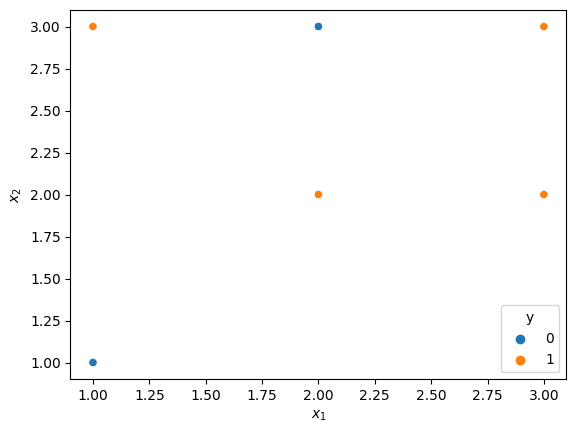

In [ ]:
# Features
x1 = [1, 1, 2, 2, 3, 3]
x2 = [1, 3, 2, 3, 2, 3]

# Response variables
y = np.array([0, 1, 1, 0, 1 , 1])

# Wrap into a dataframe
data = {"x1": x1, "x2": x2, "y": y}
df = pd.DataFrame.from_dict(data)

# Show scatter of x1 and x2
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="x1", y="x2", hue="y", ax=ax);
ax.set_xlabel("$x_1$");
ax.set_ylabel("$x_2$");

Our goal will be to implement `simple decision tree`. By simple, I precisely mean a DT that only make one split, i.e., the maximum depth is 1 (where root's node depth is 0). The objective of this section is to practice the splitting process. If you feel like it, you can implement full version of decision tree yourself. Here is an [implementation](https://github.com/jonas-mika/glass-forensic-analysis/tree/main/src/scripts/models/decision_tree) of DT from scratch with corresponding [documentation](https://ml-project.readthedocs.io/en/latest/reference/dt.html#decision-tree-module) for reference.

> Building simple decision tree

Below I implement the tree with simple API, i.e., `fit` and `predict`. The fact that maximum depth is 1 simplifies this implementation in a sense that we do not need one more class that would represent `Nodes`. 

In [ ]:
class SimpleDecisionTree:

    def __init__(self, debug=False, criterion='gini'):

        # Splitting criteria
        self.feature_idx = None
        self.features_thrs = None

        # Define to which class to classify for each split
        self.left = None
        self.right = None

        # Debugging
        self.debug = debug

        # Define possible criterions to use
        self.criterions = ["error rate", "gini", "entropy"]
        self.cidx = self.criterions.index(criterion)
    
    def fit(self, X):
        """Finds the best split for provided data and saves it as part of class attributes
        """
        # number of features
        p = X.shape[1] - 1

        # collect best impurities and splits for each feature
        best_splits = []
        best_impurities = []

        for j in range(p):
            # sorted unique feature values
            fvalues = X.iloc[:, j].unique()
            fvalues.sort()
            n = fvalues.shape[0]

            # Compute impurity for all possible splits
            splits = []
            impurities = []
            for i in range(1, n):
                # Compute the split
                prev, curr = fvalues[i - 1], fvalues[i]
                split = (prev + curr)/2

                # Compute impurities in this order: error rate, gini, entropy
                left, right = X[X.iloc[:, j] < split], X[X.iloc[:, j] >= split]
                quality = SplitQuality(left, right, f"Feature x{j + 1} and threshold {split}", debug=self.debug)
                imps = quality.summary()

                # Save the chosen impurity along with the coresponding split (threshold) value
                splits.append(split)
                impurities.append(imps[self.cidx])
            
            # Obtain the lowest impurity for given feature with corresponding split value
            idxbest = np.argmin(impurities)
            best_splits.append(splits[idxbest])
            best_impurities.append(impurities[idxbest])

        # Save the best split out of all
        self.feature_idx = np.argmin(best_impurities)
        self.features_thrs = best_splits[self.feature_idx]

        # Determine which classes would be predicted in each child node
        # -- Get the splits
        left = X[X.iloc[:, self.feature_idx] < self.features_thrs]
        right = X[X.iloc[:, self.feature_idx] >= self.features_thrs]

        # -- Get the majority classes in each node
        self.left = SplitQuality()._predict(left["y"])
        self.right = SplitQuality()._predict(right["y"])

        return self

    
    def predict(self, x):
        """For given point, predicts corresponding class.
        """
        
        if self.feature_idx is None:
            print("Tree has not been fitted yet.")
            return
        
        feature_val = x[self.feature_idx]
        if feature_val < self.features_thrs:
            return self.left
        else:
            return self.right
    
    def summary(self):
        print(f"Best split information\n---")
        print(f">> use feature x{self.feature_idx + 1}")
        print(f">> and make a split at {self.features_thrs}")

... this exercise offers plenty of opportunities to do some coding 🥵. Anyway, let's test this out:

In [ ]:
simpledt = SimpleDecisionTree(debug=True, criterion='gini').fit(df)
simpledt.summary()

Weighted impurity for the Feature x1 and threshold 1.5 split
---
Error rate: 0.333
Gini: 0.417
Entropy: 0.606

Weighted impurity for the Feature x1 and threshold 2.5 split
---
Error rate: 0.333
Gini: 0.333
Entropy: 0.462

Weighted impurity for the Feature x2 and threshold 1.5 split
---
Error rate: 0.167
Gini: 0.267
Entropy: 0.417

Weighted impurity for the Feature x2 and threshold 2.5 split
---
Error rate: 0.333
Gini: 0.444
Entropy: 0.637

Best split information
---
>> use feature x2
>> and make a split at 1.5


Fitting seems to work great 🥳, let's now try to classify some points:

In [ ]:
p1 = np.array([3, 2.50]) # expext it to be classified as 1
simpledt.predict(p1)

1

In [ ]:
p2 = np.array([3, 1.25]) # expext it to be classified as 0
simpledt.predict(p2)

0

Amazing,works as expected. Finally, let's compute the information gain:

In [ ]:
all_quality = SplitQuality(debug=True)
all_quality.summary2(df["y"], "all data");

Impurity for the all data split
---
Error rate: 0.333
Gini: 0.444
Entropy: 0.637



Nice, we can see that we roughly gained $0.444-0.267 = 0.177$ information according to the gini index.

> Section summary

In this section, we implemented simple decision tree which demonstrates two core concepts: model fitting and predicting. Hopefully, together with the previous section you now feel comfortable how DTs work not only on a high level but also on a lower level. I highly suggest you try to implement this simple version DT by yourself since I believe it allows you to nicely connect all the concepts together.

### Classification with decision trees using sklearn

---

> Intro to the section

The aim of this section is to explore possibilies when using `sklearn` for Decision Trees. Therefore, main learning takeaway from this section is to know `how to use sklearn to train DT as well as make predictions`. This might seem like a trivial task, however, there are many options that one can tune and as such it is important to understand these parameters.

Within the scope of this section, we will use dataset from the previous exercises:

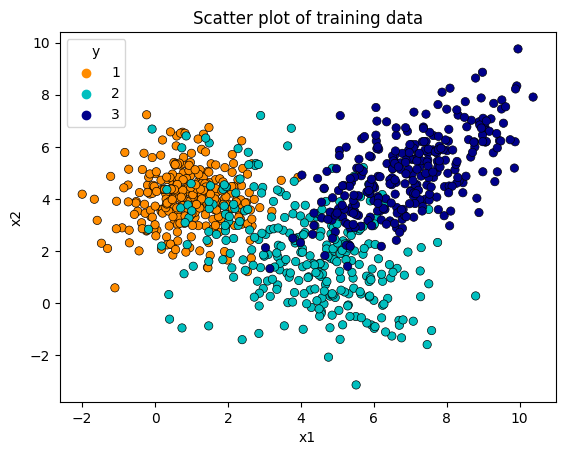

In [ ]:
# Training
training = pd.read_csv("Ex1-training.csv")
X_train, y_train = training[["x1", "x2"]], training["y"]

# Test
test = pd.read_csv("Ex1-test.csv")
X_test, y_test = test[["x1", "x2"]], test["y"]

# Plot training
fig, ax = plt.subplots()
cmap_bold = ['darkorange', 'c', 'darkblue']
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_title("Scatter plot of training data");

> Building and visualising decision tree

Let's start by fitting the model. We will use the following `hyper-parameters`:
- `criterion`: as discussed in the above section `gini` or `entropy`
- `max depth`: the maximum depth of the tree. This is important parameter that allows you to prevent overfitting of the tree. Otherwise, the feature space would be split into regions such that either the region would be pure or it would contain only 2 samples
- `splitter`: there are two options - best and random. I demonstrated how the best option works above, for random option you can tell the classifier that for each split, it can choose randomly $k$ features and based on these find the best split
- `random state`: In general, according to sklearn's docs: 

> To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer

which means that even if we do not choose features at random, we still need to specify random state. (not exactly sure why)

In [ ]:
dt = DecisionTreeClassifier(random_state=11, max_depth=3, criterion="gini", splitter='best').fit(X_train, y_train)

Next, let's visualize the decision regions made by our tree:

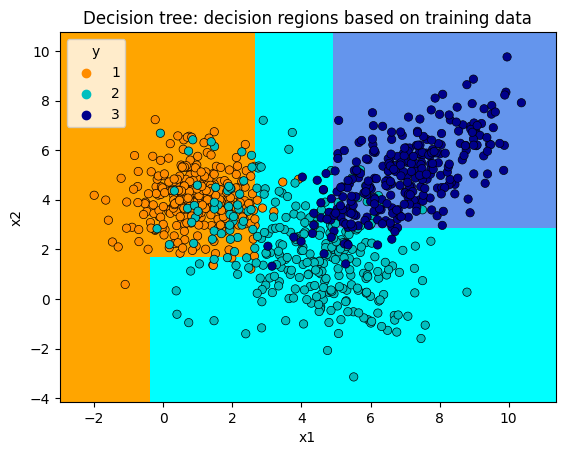

In [ ]:
# Define plot
fig, ax = plt.subplots()

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Mesh step
h = 0.02

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"Decision tree: decision regions based on training data");

Looks like a good fit. Let's compute `training accuracy`:

In [ ]:
acc_train = dt.score(X_train, y_train)
print("Training accuracy: {:.3f}".format(acc_train))

Training accuracy: 0.886


It's interesting to compte the decision boundaries to model like `QDA`:

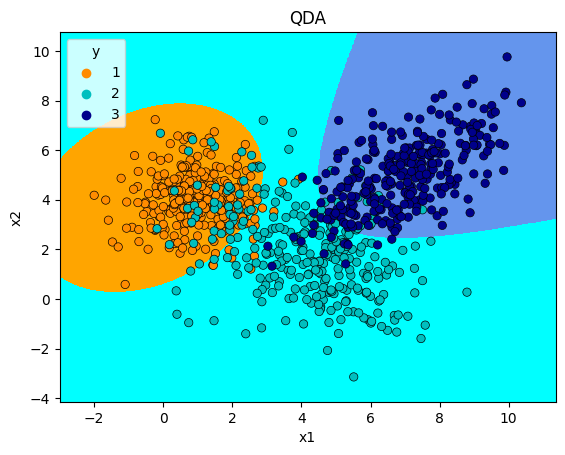

In [ ]:
# Fit QDA
qda = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)

# Define plot
fig, ax = plt.subplots()

# Make the predictions
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_xlim(xx.min(), xx.max());
ax.set_ylim(yy.min(), yy.max());
ax.set_title(f"QDA");

The decision regions seems to overlap, but at the same time QDA's shape is way more flexible compare to decision tree which is essentially straight lines (vertical or horizontal) through the feature space. Since our decision tree model's depth is only 3, we can also visualize the tree strucure:

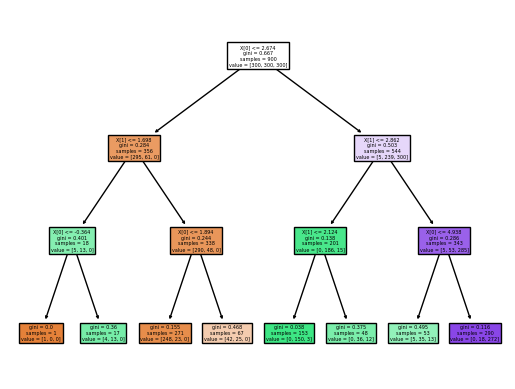

In [ ]:
# Define plot
fig, ax = plt.subplots()

# Visualize the structure
tree.plot_tree(dt, filled=True, ax=ax);

For instance, we can see that the first split is via $x_1$ at $x_1 = 2.67$, which actually makes sense if we look at the plot. In addition, if you look at impurity of each node (measured by `Gini`), then parent's impurity should be higher than the `weighted` average of impurities of its children nodes. Finally, for instance the `orange leaf` node in the lower left corner, corresponds to the rectangular region in the lower left cornerof the decision regions plot.

> Tuning max depth

As I have mentioned above, `max depth` parameter allows us regularize the tree. In other words, by setting the max depth, our hope is that the tree will then generalize well on test data. Let's first a new dt classifier which will have no limit on its depth:

In [ ]:
dt2 = DecisionTreeClassifier(random_state=11, max_depth=None, criterion="gini", splitter='best').fit(X_train, y_train)

Let's again visualize the decision regions:

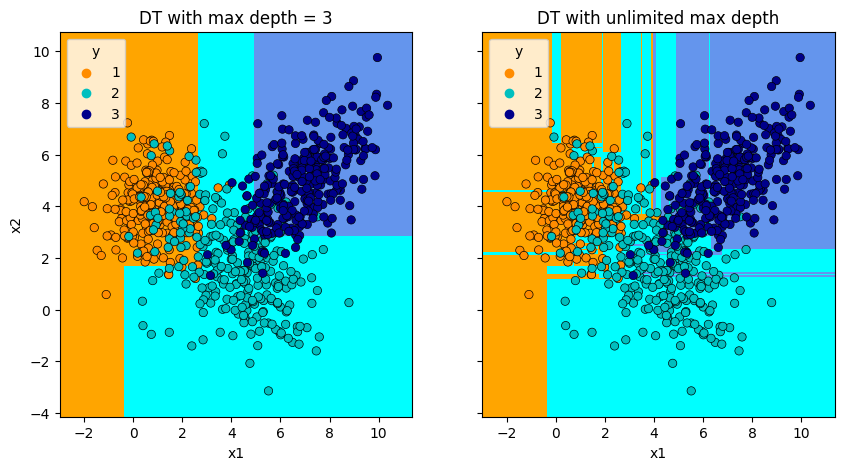

In [ ]:
# Define plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

Z1 = dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = dt2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the results into a color plot
Z1 = Z1.reshape(xx.shape);
ax[0].contourf(xx, yy, Z1, cmap=cmap_light);

Z2 = Z2.reshape(xx.shape);
ax[1].contourf(xx, yy, Z2, cmap=cmap_light);

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[0]);
ax[0].set_title("DT with max depth = 3");
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[1]);
ax[1].set_title("DT with unlimited max depth");

You can now clearly see the difference, we still have the major regions, but we also have these tiny new tiny regions. This looks like overfitting. Let's see the relationship between `max depth` and corresponding training and test error:

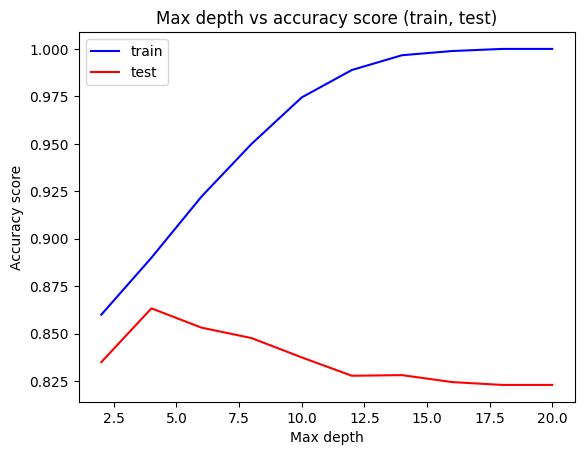

In [ ]:
# Define depths
depths = [i + 1 for i in range(1, 20, 2)]
    
# Save accuracy scores for different depths
acc_train = []
acc_test = []
    
for depth in depths:

    # Train a decision Tree
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42).fit(X_train, y_train)

    # Compute accuracy scores
    acc_train.append(accuracy_score(y_train, clf.predict(X_train)))
    acc_test.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Define plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(depths, acc_train, c='blue', label='train')
ax.plot(depths, acc_test, c='red', label='test')

# * Add labels
ax.set_ylabel("Accuracy score")
ax.set_xlabel("Max depth")
ax.set_title(f"Max depth vs accuracy score (train, test)")
ax.legend();

This graphs confirms our assumption, for depths higher than 3, we have `low bias` but high variance. Therefore, when training Decision tree, you should use for grid search which tries all possible combinations of model's `hyperparameters` (including max depth), each combination is cross validated and then the combination with best cross validated metric of interest is chosen. Alternatively, you could also simply fit the model on the training data and then check on validation data whether there is a signifficance difference in metric of interest (e.g. accuracy), if so, then you should stop incrementing the given hyper parameter. In our case, this would be around max depth 3 or 4. Because for instance we reach 95 % training accuracy at the following depth:

In [ ]:
idx95 = acc_train.index(.95)
depths[idx95]

8

But that correspond to the following test accuracy:

In [ ]:
acc_test[idx95]

0.8476666666666667

which is relatively signifficant drop. Therefore, it is much better to stop splitting earlier in the tree building process.

> Other ways of regularising DTs 

So far, we have only talked about `max depth` as a way to regularize decision tree, but of course there others such as:

- `min_samples_split`: the minimum number of samples required to split an internal node

- `min_samples_leaf`: the minimum number of samples required to be at a leaf node

Let's try this in practice, we will again omit max depth, but specify the above two parameters:

In [ ]:
dt3 = DecisionTreeClassifier(random_state=11, max_depth=None, min_samples_split=15, min_samples_leaf=15).fit(X_train, y_train)

Again, we can visualize it against our initial `dt`:

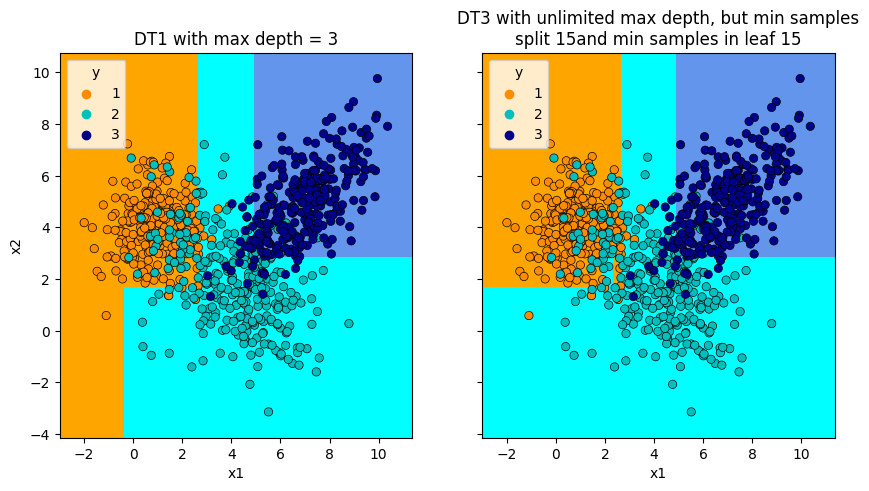

In [ ]:
# Define plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

Z1 = dt.predict(np.c_[xx.ravel(), yy.ravel()])
Z3 = dt3.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the results into a color plot
Z1 = Z1.reshape(xx.shape);
ax[0].contourf(xx, yy, Z1, cmap=cmap_light);

Z3 = Z3.reshape(xx.shape);
ax[1].contourf(xx, yy, Z3, cmap=cmap_light);

# Plot also the training points
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[0]);
ax[0].set_title("DT1 with max depth = 3");
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax[1]);
ax[1].set_title("DT3 with unlimited max depth, but min samples\nsplit 15and min samples in leaf 15");

It seems like that the `dt3` is now even more regularized despite having unlimited depth which makes sense since we added min samples split as well as min number of samples to be present in a leaf node.

> Section summary

In this, we first explored how we can visualize our trained decision tree model. We then discussed the relationship between regularization parameter max depth and DTs capability to generalize. Therefore, my hope is that after going through this section, you have a good grasp of how to build solid decision tree model for some classification problem.

### Regression with decision trees using sklearn

---

> Intro to the problem

This section is in its essence very similar to the previous one with the only difference that now we are in the `regression` setting. We will first generate the data:

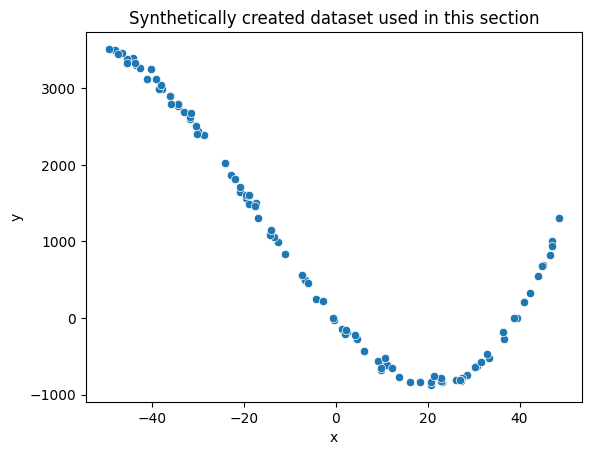

In [ ]:
# Generate the data
np.random.seed(42)
x = np.random.uniform(low= -50, high=50, size=(100,))
X = x.reshape(-1, 1)
y = 0.02 * x ** 3 + x ** 2 - 70 * x - 3
y = y + (np.random.randn(100) * 50) # add noise

# Make a simple scatter plot
fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=y, ax=ax);
ax.set_ylabel("y");
ax.set_xlabel("x");
ax.set_title("Synthetically created dataset used in this section");

Then our task will be to first fit and visualize the given model. We will then examine again the effect of max depth on the model.

> Building and visualising the model

We first fit the model with `max depth = 2`:

In [ ]:
dtreg = DecisionTreeRegressor(max_depth=2).fit(X, y)

For visualization of the regressor, we can define the following helper function:

In [ ]:
def plot_regression_predictions(tree_reg, X, y, axes=[-50, 50, -1000, 3500], ylabel="$y$"):

    # Define the feature space
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)

    # Get corresponding predictions
    y_pred = tree_reg.predict(x1)

    # Plot the data
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

    # Add labels
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

Let's test it out:

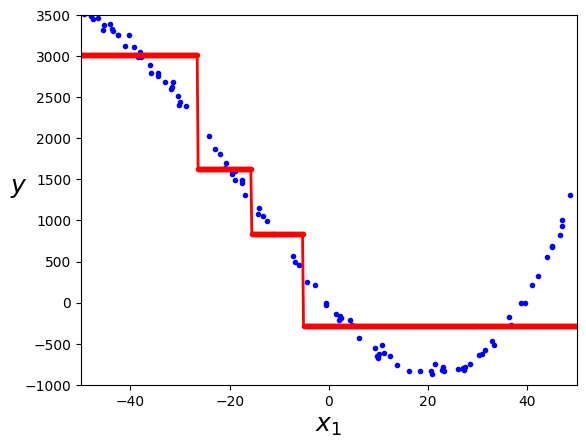

In [ ]:
plot_regression_predictions(dtreg, X, y)

We can see that our tree has `3 decisions` in total. (vertical lines) The horizontal lines then represent the mean of values within that given range. For instance, the first horizontal line corresponds to $mean(y)$ for all $y$ whose $x$ lies between $-\infty$ and -25 (roughly). We can also verify through plotting the actual tree structure:

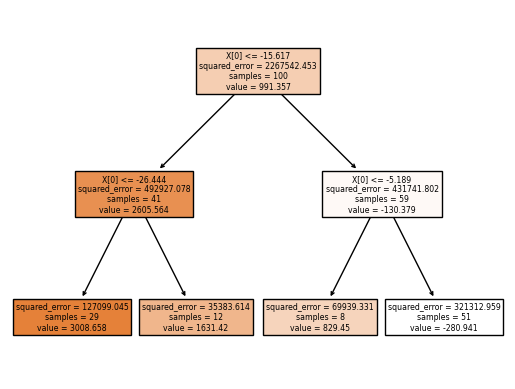

In [ ]:
# Define plot
fig, ax = plt.subplots()

# Visualize the structure
tree.plot_tree(dtreg, filled=True, ax=ax);

You can see the $mean(y)$ for the range I specified above is $3008.658$, which makes sense also looking back on the plot.

> Impact of max depth on the regression results

Let's examine how different `max depths` influence predictions of our model:

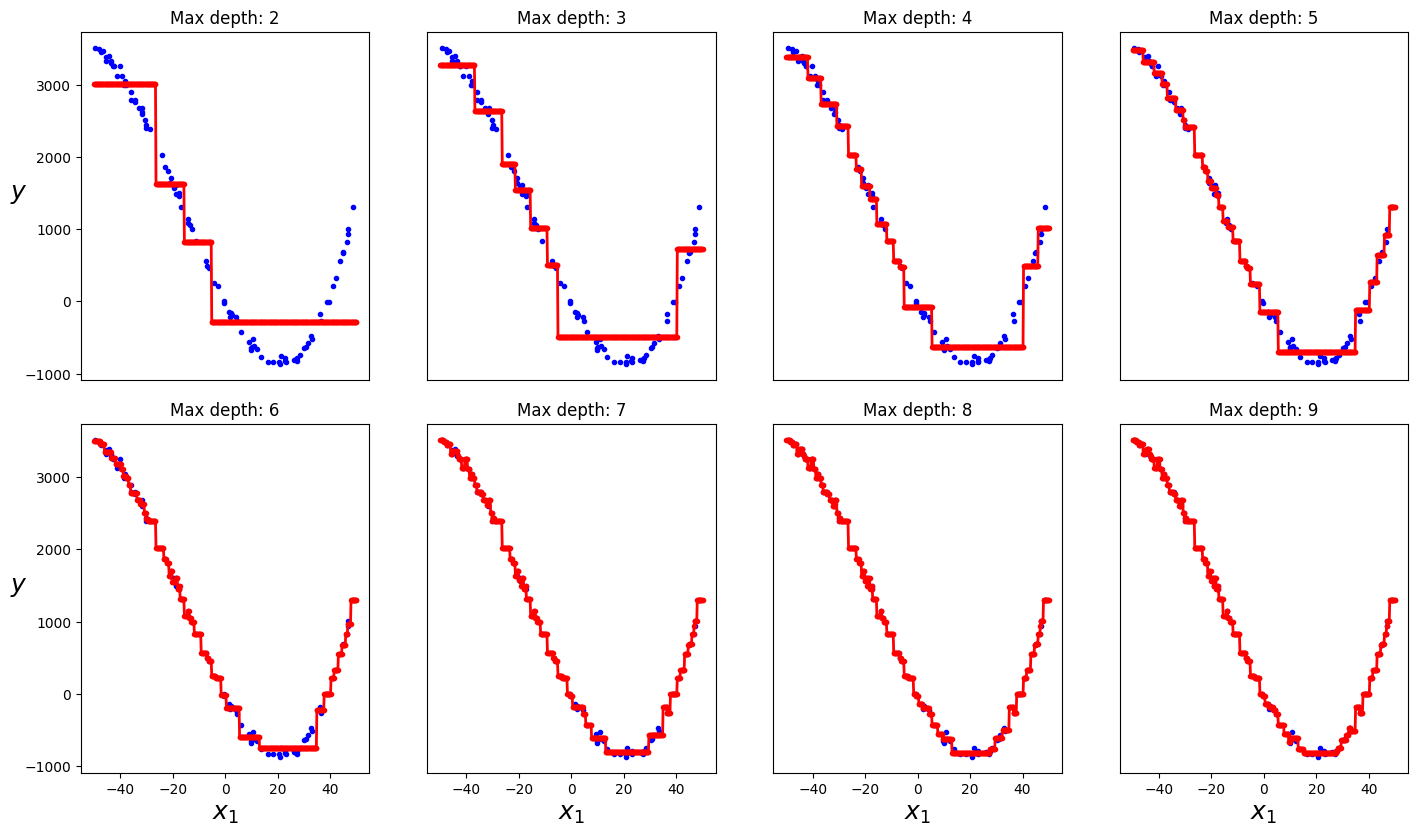

In [ ]:
# Define depth
depths = [i for i in range(2, 11)]

# Define a subplot
fig, axs = plt.subplots(2, 4, figsize=(14, 8))
fig.tight_layout()

for i, row in enumerate(axs):
    
    for j, ax in enumerate(row):
                
        # Train
        depth = depths.pop(0)
        tree_reg = DecisionTreeRegressor(max_depth=depth)
        tree_reg.fit(X, y)

        # Show the decision boundary
        x1 = np.linspace(-50, 50, 500).reshape(-1, 1)
        y_pred = tree_reg.predict(x1)
        ax.plot(X, y, "b.")
        ax.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")
        ax.set_title(f"Max depth: {depth}")
        
        # Additional settings
        if j == 0:
            ax.set_ylabel("$y$", fontsize=18, rotation=0)
        else:
            ax.set_yticks([])
        
        if i == 1:
            ax.set_xlabel("$x_1$", fontsize=18)
        
        if i == 0:
            ax.set_xticks([])

We can clearly see that the model is fitting the data better and better as we increase max depth. Same situation as we saw in the classification setting. You are overfitting the data and thus we can expect the generalization of models with high max depth to be poor. With that being said, DT are a great tool for regression, one of its main advantages being the interprettability as well as ability to fit complex patterns.

> Section summary

We concluded this exercise session with understanding how to build and visualize regression decision tree. We have also confirmed the same conclusion as in the classification setting, i.e., max depth needs to be regularized to prevent overfitting. Finally, we summarized why it is actually good idea to use regression as one of the starting algorithms for regression problems.

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=506ec0b2-51de-4615-90b8-6a339c402dce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>